# Portfolio Optimization
### Mean-Variance Optimization of a portfolio contingent on sector, asset type and location using Capital Asset Pricing Model (CAPM) and Ledoit-Wolf shrinkage. The goal is to have a diversified portfolio with low covariance between assets and maximise the Sharpe ratio subject to aggregate constraints. 

In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
from pypfopt import risk_models, plotting, expected_returns, EfficientFrontier, objective_functions
import warnings
from scipy.optimize import minimize
warnings.filterwarnings('ignore')

#### Selecting researched stocks from multiple sectors from US-based and Non-US based companies while also including some more risky high-yielding investments in cryptocurrencies. The goal is to have evenly spread US and Non-US assets diversified upon industry and location
1. US Sectorized Stocks 
    1. Financial: Berkshire Hathaway (BRK-B), Bank of America (BAC), JPMorgan Chase & Co (JPM)
    2. Healthcare: Vertex Pharmaceuticals (VRTX), Gilead Sciences (GILD)
    3. Tech & IT: Microsoft (MSFT), Apple (AAPL), NVIDIA (NVDA), Uber Technologies Inc. (UBER)
    4. Consumer Discretionary: Amazon (AMZN), Costco (COST), Tesla (TSLA)
    5. Consumer Staples: The Coca-Cola Company (KO), Hershey’s (HSY)
    6. Energy: Chevron Corporation (CVX) 
2. Non-US Sectorized Stocks (based on iShares MSCI EAFE ETF targeting large- and mid-capitalizion developed market equities excluding North America)
    1. Financial: HSBC Holdings plc (HSBA.L), Common Wealth Bank of Australia (CBA.AX)
    2. Healthcare: Novo Nordisk (NOVO-B.CO), Novartis International AG (NOVN.SW), AstraZeneca (AZN.L), Roche Holging AG (ROG.SW)
    3. Information Technology: ASML Holding N.V. (ASML), SAP SE (SAP)
    4. Consumer Discretionary: LVMH Moët Hennessy — Louis Vuitton (MC.PA), Toyota (7203.T), Sony (6758.T)
    5. Consumer Staples: Nestle SA (NESN.SW)
    6. Energy: Shell plc (SHEl.L), TotalEnergies SE (TTE.PA), BHP Group Ltd (BHP.AX)
3. Cryptocurrencies (based on Bitwise 10 Crypto Index Units Beneficial Interest comprised of top 10 most highly valued cryptocurrencies)
    1. Bitcoin, Ethereum, Solana, XRP, Cardano, Avalanche, Polkadot, Polygon, Chainlink, Litecoin

In [2]:

us_tickers = ["AMZN", "MSFT", "AAPL", "NVDA", "COST", "KO", 'HSY', 'VRTX', 'GILD', 'BRK-B', 'BAC', 'JPM', 'UBER', 'TSLA', 'CVX']
efa_tickers = ['NOVO-B.CO', 'NESN.SW', 'ASML.AS', 'SHEL.L', 'NOVN.SW', 'AZN.L', 'MC.PA',
                'ROG.SW', 'BHP.AX', '7203.T', 'TTE.PA', 'HSBA.L', 'SAP.DE', 'CBA.AX', '6758.T']
crypto_tickers = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'XRP-USD', 'ADA-USD', 'AVAX-USD', 'DOT-USD', 'MATIC-USD', 'LINK-USD', 'LTC-USD']

#This division is consistent with information from NASDAQ

energy_tickers = ['CVX', 'SHEL.L', 'TTE.PA', 'BHP.AX']
health_care_tickers = ['VRTX', 'GILD', 'NOVO-B.CO', 'NOVN.SW', 'AZN.L', 'ROG.SW']
financial_tickers = ['BRK-B', 'BAC', 'JPM', 'HSBA.L', 'CBA.AX']
consumer_discretionary_tickers = ['AMZN', 'COST', 'TSLA', 'MC.PA', '7203.T', '6758.T']
consumer_staples_tickers = ['KO', 'HSY', 'NESN.SW']
tech_it_tickers = ['MSFT', 'AAPL', 'NVDA', 'UBER', 'ASML.AS', 'SAP.DE']

In [3]:
#Load historical data (5 years)
tickers = us_tickers + efa_tickers + crypto_tickers
end_date = datetime.today()
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*5)
data = yf.download(tickers = tickers, start = start_date, end = end_date)

#We will also download geo/asset restricted data merely for vizaulization purposes
us_data = yf.download(tickers = us_tickers, start = start_date, end = end_date)
efa_data = yf.download(tickers = efa_tickers, start = start_date, end = end_date)
crypto_data = yf.download(tickers = crypto_tickers, start = start_date, end = end_date)

data.stack()

[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  10 of 10 completed


Adj Close        Close         High          Low  \
Date                                                                     
2019-01-14 AAPL       35.992901    37.500000    37.817501    37.305000   
           ADA-USD     0.044059     0.044059     0.044484     0.040204   
           AMZN       80.860497    80.860497    82.410004    79.757500   
           ASML.AS   131.823853   138.899994   140.820007   138.000000   
           AZN.L    4821.660645  5509.000000  5670.000000  5477.000000   
...                         ...          ...          ...          ...   
2024-01-12 TSLA      218.889999   218.889999   225.339996   217.149994   
           TTE.PA     60.139999    60.139999    60.840000    60.090000   
           UBER       63.200001    63.200001    64.919998    63.000000   
           VRTX      433.399994   433.399994   434.850006   431.140015   
           XRP-USD     0.570299     0.570299     0.603206     0.561413   

                           Open        Volume  
Date                                           
2019-01-14 AAPL       37.712502  1.297568e+08  
           ADA-USD     0.040249  3.026913e+07  
           AMZN       80.750000  1.201180e+08  
           ASML.AS   139.559998  1.193495e+06  
           AZN.L    5600.000000  4.052678e+06  
...                         ...           ...  
2024-01-12 TSLA      220.080002  1.228890e+08  
           TTE.PA     60.250000  3.034026e+06  
           UBER       63.200001  2.636710e+07  
           VRTX      432.489990  1.183600e+06  
           XRP-USD     0.602096  1.716194e+09  

[54201 rows x 6 columns]

#### We will use Ledoit-Wolf shrinkage estimate to estimate the optimal value for the shrinkage constant for our covariance matrix. Even though sample covariance matrix is unbiased estimator, it suffers from misspecification error and a lack of robustness, meaning that the optimizer may give extra credence to erroneous values.

<AxesSubplot:>

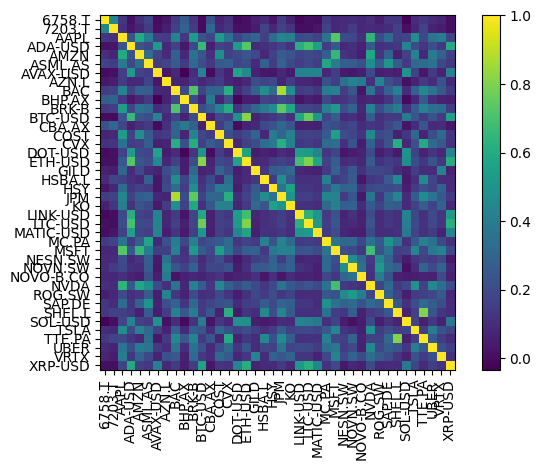

In [4]:
#It is a little bit difficult to see, but it's clear that overall the covaraince between assets is small
S = risk_models.CovarianceShrinkage(data['Adj Close']).ledoit_wolf() 
plotting.plot_covariance(S, plot_correlation=True)

Text(0.5, 1.0, 'Covariance Matrix for selected Cryptocurrencies')

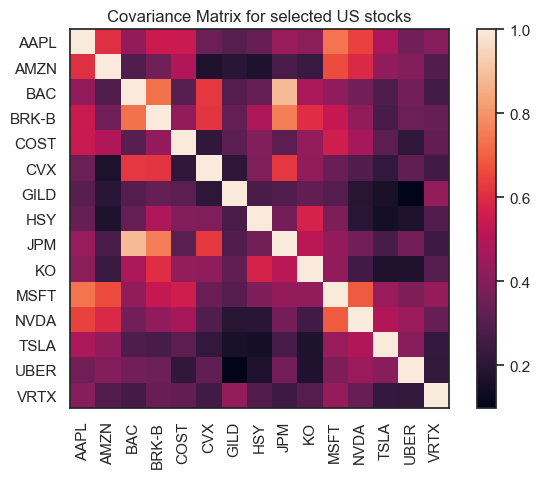

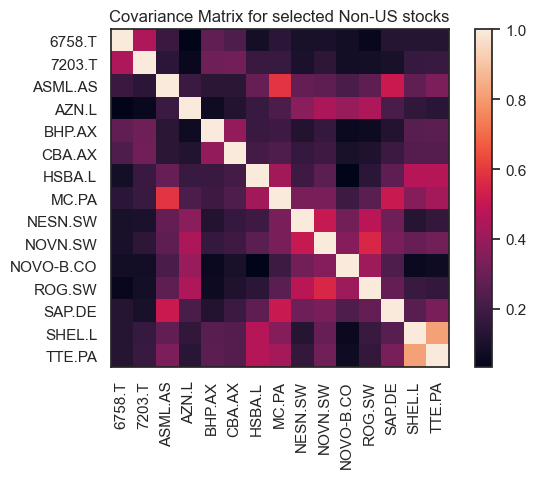

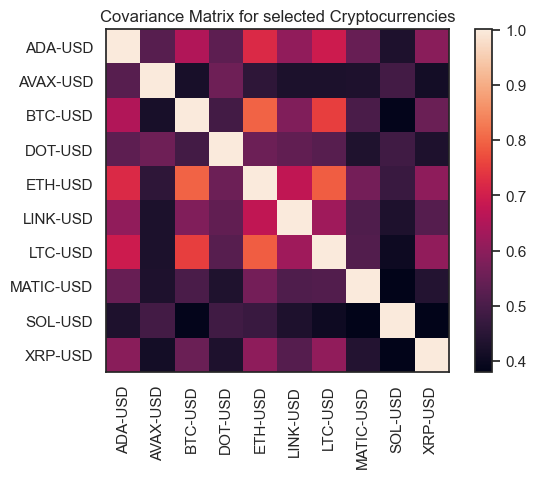

In [6]:
#The coloring is unconsistent (sometimes blue/yellow or black/white or purplish)
#The black and white is especially unpleasant and difficult to understand
#So we will use some seaborn styling to make it look better
#As we can see, Non-US assets have much lower covariance meaning that they will hold majority of the weight
import seaborn as sns
sns.set(style="white")  
cmap = sns.diverging_palette(220, 20, as_cmap=True) 
S1 = risk_models.CovarianceShrinkage(us_data['Adj Close']).ledoit_wolf() 
plotting.plot_covariance(S1, plot_correlation=True, cmap=cmap)
plt.title("Covariance Matrix for selected US stocks")
S2 = risk_models.CovarianceShrinkage(efa_data['Adj Close']).ledoit_wolf() 
plotting.plot_covariance(S2, plot_correlation=True, cmap=cmap)
plt.title("Covariance Matrix for selected Non-US stocks")
S3 = risk_models.CovarianceShrinkage(crypto_data['Adj Close']).ledoit_wolf() 
plotting.plot_covariance(S3, plot_correlation=True, cmap=cmap)
plt.title("Covariance Matrix for selected Cryptocurrencies")


#### For calculating the returns, we will use CAPM since the portfolio consists solely of equities

Text(0.5, 1.0, 'Expected return for each asset')

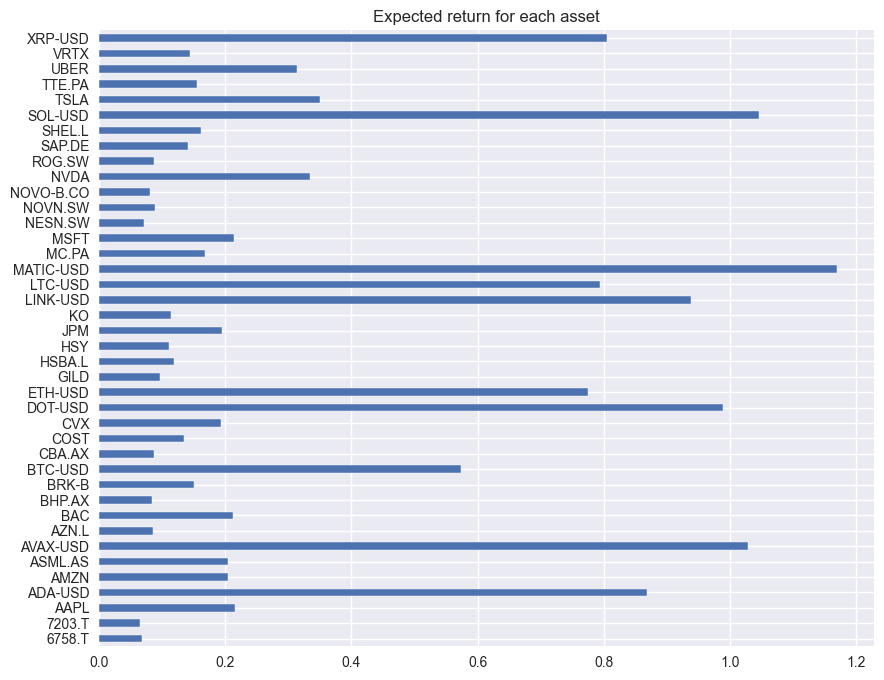

In [7]:
plt.style.use('seaborn')
mu = expected_returns.capm_return(data['Adj Close'])
mu.plot.barh(figsize=(10,8))
plt.title('Expected return for each asset')

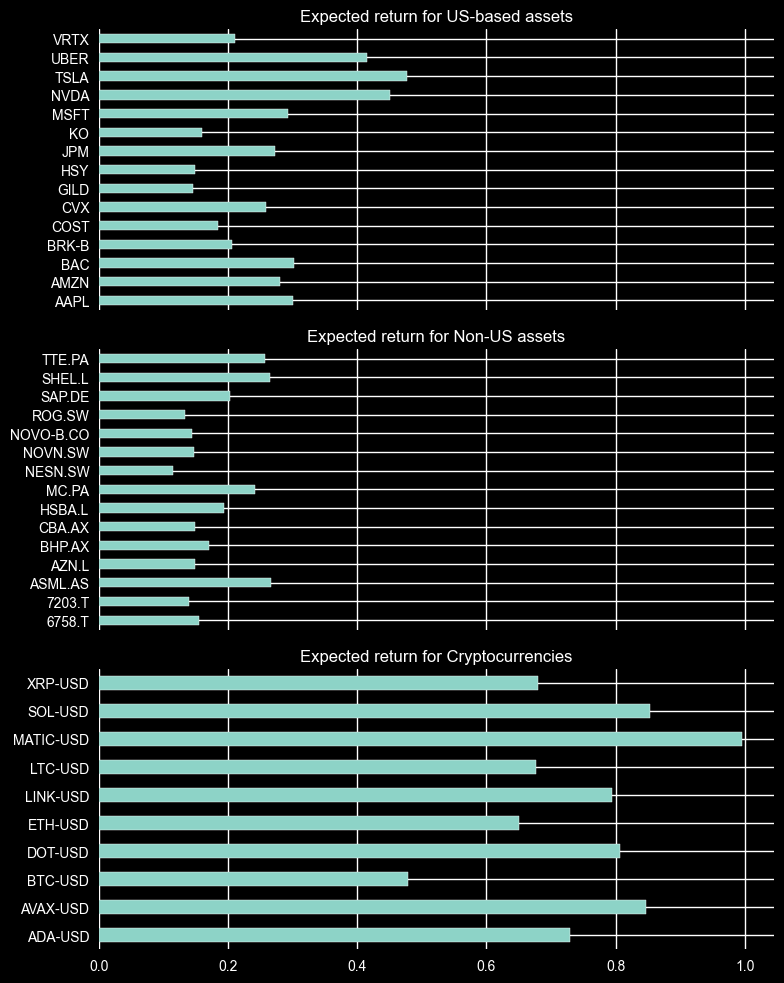

In [8]:
mu1 = expected_returns.capm_return(us_data['Adj Close'])
mu2 = expected_returns.capm_return(efa_data['Adj Close'])
mu3 = expected_returns.capm_return(crypto_data['Adj Close'])
with plt.style.context("dark_background"):
    fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
    mu1.plot.barh(ax=axes[0])
    axes[0].set_title('Expected return for US-based assets')
    mu2.plot.barh(ax=axes[1])
    axes[1].set_title('Expected return for Non-US assets')
    mu3.plot.barh(ax=axes[2])
    axes[2].set_title('Expected return for Cryptocurrencies')
    plt.tight_layout()
    plt.show()


#### It's a little bit diffcult to pass in complex constraints or objectives in PyPortfolio since there isn't much documentation on it. For constraints, it is only possible to pass a sector constraint, so assuming we divided stocks by sectors, we wouldn't be able to also control for the location or vice versa because dictionaries can't have the same key. However, we could use singular constrains with a loop to achieve this goal, but we need to account for reordering (the weights don't came in the same order as the tickers list). It's also possible to use CVXPY library instead where it's easier to pass in custom constraints and objectives. So it is possible to do weight optimization through it and then run the statistics manually, however the performance is quite questionable and optimization may fail, so I will continue with Efficient Frontier PyPortfolioOpt as performance is my main goal.

In [9]:
#First we will need to make some dictionaries
us_tickers_dict = {ticker: "US" for ticker in us_tickers}
efa_tickers_dict = {ticker: "Non-US" for ticker in efa_tickers}
crypto_tickers_dict = {ticker: "Crypto" for ticker in crypto_tickers}
energy_dict = {ticker: "Energy" for ticker in energy_tickers}
health_dict = {ticker: 'Healthcare' for ticker in health_care_tickers}
financial_dict = {ticker: "Finance" for ticker in financial_tickers}
consumer_discretionary_dict = {ticker: "Consumer Discretionary" for ticker in consumer_discretionary_tickers}
consumer_staples_dict = {ticker: "Consumer Staples" for ticker in consumer_staples_tickers}
tech_it_dict = {ticker: "Tech/IT" for ticker in tech_it_tickers}

In [10]:
ef = EfficientFrontier(
    expected_returns=mu,  
    cov_matrix=S,  
    weight_bounds=(0, 1),
)
sector_tickers_combined = {**energy_dict, **health_dict, **financial_dict, **consumer_discretionary_dict, **consumer_staples_dict, **tech_it_dict, **crypto_tickers_dict}
#combine the dictionaries
sector_mapper = sector_tickers_combined
sector_lower = {
    #at least 10% of the portoflio in each indusrty, and 20% for Healthcare
    "Energy": 0.1, 
    "Healthcare": 0.2,
    "Finance": 0.1,
    "Consumer Discretionary": 0.1,
    "Consumer Staples": 0.1,
    "Tech/IT": 0.1
}
sector_upper = {
    #at most 14% of the portfolio can be invested in crypto, and at most 25% for any sector
    'Crypto': 0.14,
    "Energy": 0.25, 
    "Healthcare": 0.25,
    "Finance": 0.25,
    "Consumer Discretionary": 0.25,
    "Consumer Staples": 0.25,
    "Tech/IT": 0.25
}
#Non-US stocks must have at least 40% of the weight in our portfolio
ticker_to_index = {ticker: i for i, ticker in enumerate(tickers)} #this line account for ordering
def min_non_us_weight(weights):
    efa_indices = [ticker_to_index[ticker] for ticker in efa_tickers]
    return cp.sum([weights[i] for i in efa_indices]) >= 0.4
ef.add_constraint(min_non_us_weight)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
# ef.add_objective(objective_functions.L2_reg, gamma=0.1) 
ef.efficient_risk(0.15)
# ef.max_sharpe()
weights = ef.clean_weights()
# Display the resulting weights and other properties
print("Optimized Weights from EfficientFrontier Object:")
print(weights)

Optimized Weights from EfficientFrontier Object:
OrderedDict([('6758.T', 0.03596), ('7203.T', 0.03775), ('AAPL', 0.00577), ('ADA-USD', 0.0), ('AMZN', 0.01882), ('ASML.AS', 0.0), ('AVAX-USD', 0.03836), ('AZN.L', 0.02646), ('BAC', 0.0), ('BHP.AX', 0.04509), ('BRK-B', 0.04952), ('BTC-USD', 0.0), ('CBA.AX', 0.04901), ('COST', 0.04577), ('CVX', 0.01373), ('DOT-USD', 0.06638), ('ETH-USD', 0.0), ('GILD', 0.04383), ('HSBA.L', 0.04749), ('HSY', 0.04773), ('JPM', 0.0), ('KO', 0.02782), ('LINK-USD', 0.0), ('LTC-USD', 0.0), ('MATIC-USD', 0.01007), ('MC.PA', 0.0), ('MSFT', 0.02883), ('NESN.SW', 0.09125), ('NOVN.SW', 0.03042), ('NOVO-B.CO', 0.02485), ('NVDA', 0.0), ('ROG.SW', 0.05776), ('SAP.DE', 0.02855), ('SHEL.L', 0.01721), ('SOL-USD', 0.02371), ('TSLA', 0.0089), ('TTE.PA', 0.02397), ('UBER', 0.03685), ('VRTX', 0.01669), ('XRP-USD', 0.00149)])


In [11]:
ef.portfolio_performance(verbose=True)

#Some snapshots of attempted models

#without industry sector constraints (the only constraint was >=0.4 non us and  <=0.1 crypto) 
# Expected annual return: 21.7%
# Annual volatility: 13.8%
# Sharpe Ratio: 1.43

#max sharpe no constraints at all; 27% went into crypto 
#the sharpe ratio is the highest, however it violates my requirement with crypto weight being too high
# Expected annual return: 37.2%
# Annual volatility: 22.7%
# Sharpe Ratio: 1.55

#no sector constraints, l2 regularization, gamma=0.1, risk = 0.14;
# Non-US: 0.543, US: 0.319, Crypto: 0.138 // 14% in Crypto with 14% annual volatility is acceptable 
# Expected annual return: 22.6%
# Annual volatility: 14.0%
# Sharpe Ratio: 1.47

#l2 regularization with all constraints 
# Expected annual return: 21.8%
# Annual volatility: 14.0%
# Sharpe Ratio: 1.42

#max sharpe with all constraints
# Expected annual return: 21.5%
# Annual volatility: 13.7%
# Sharpe Ratio: 1.42

# Winner 
# All constraints, 14% max in crypto, with volatility capped at 15%
# Expected annual return: 24.8%
# Annual volatility: 15.0%
# Sharpe Ratio: 1.52


Expected annual return: 24.8%
Annual volatility: 15.0%
Sharpe Ratio: 1.52


(0.24776811636891402, 0.15000000010421408, 1.5184541080711316)

<AxesSubplot:xlabel='Weight'>

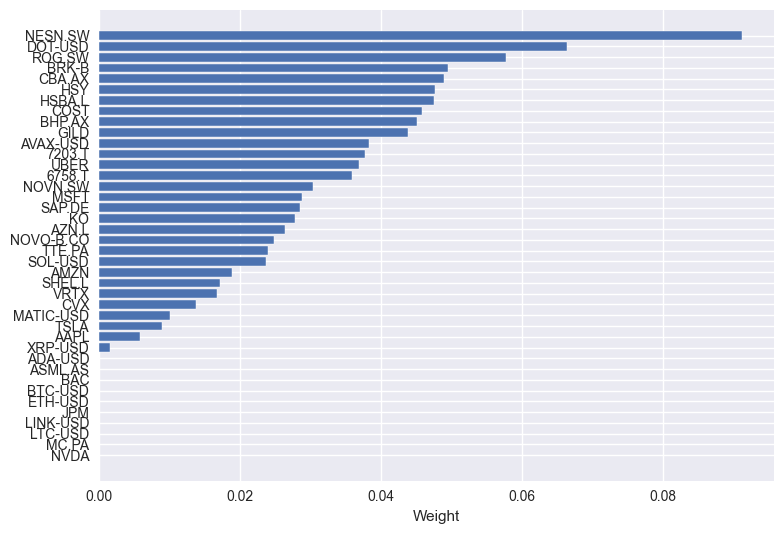

In [12]:
plotting.plot_weights(weights=weights)


In [13]:
for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in weights.items():
        if sector_mapper[t] == sector:
            total_weight += w
    print(f"{sector}: {total_weight:.3f}")

Crypto: 0.140
Consumer Staples: 0.167
Consumer Discretionary: 0.147
Healthcare: 0.200
Finance: 0.146
Energy: 0.100
Tech/IT: 0.100


In [14]:
import plotly.express as px
us_weight = sum(weights[ticker] for ticker in us_tickers if ticker in weights)
efa_weight = sum(weights[ticker] for ticker in efa_tickers if ticker in weights)
crypto_weight = sum(weights[ticker] for ticker in crypto_tickers if ticker in weights)
labels = ['US Stocks', 'EFA Stocks', 'Crypto']
values = [us_weight, efa_weight, crypto_weight]
fig = px.pie(names=labels, values=values, title='Portfolio Allocation')
fig.update_traces(marker=dict(colors=['#001f3f', '#003366', '#00539b']))
fig.update_layout(width=400, height=400)
fig.show()

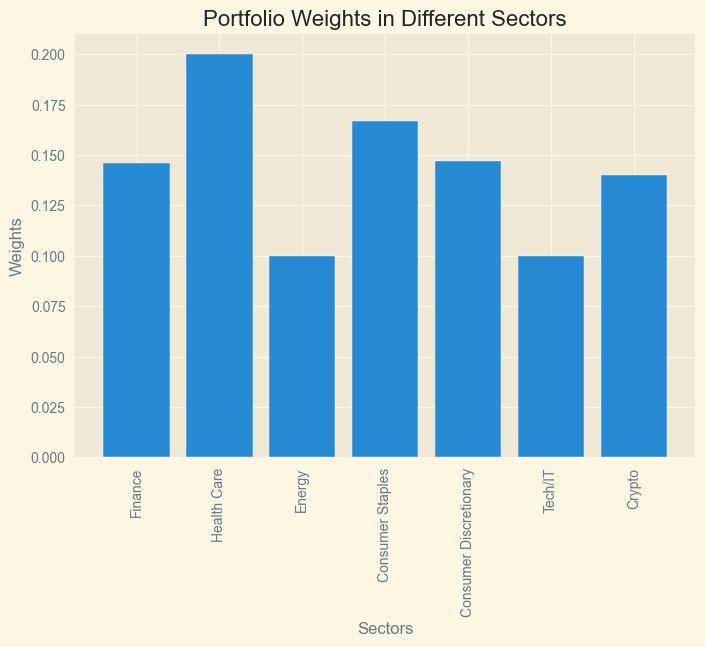

In [15]:
finance_weights = [weights[ticker] for ticker in financial_tickers]
health_weights = [weights[ticker] for ticker in health_care_tickers]
energy_weights = [weights[ticker] for ticker in energy_tickers]
consumer_staples_weights = [weights[ticker] for ticker in consumer_staples_tickers]
consumer_discretionary_weights = [weights[ticker] for ticker in consumer_discretionary_tickers]
tech_it_weights = [weights[ticker] for ticker in tech_it_tickers]
crypto_weights = [weights[ticker] for ticker in crypto_tickers]
# Plotting
plt.style.use("Solarize_Light2")
sectors = ['Finance', 'Health Care', 'Energy', 'Consumer Staples', 'Consumer Discretionary', 'Tech/IT', 'Crypto']
tot_weights = [sum(finance_weights), sum(health_weights), sum(energy_weights), sum(consumer_staples_weights), 
               sum(consumer_discretionary_weights), sum(tech_it_weights), sum(crypto_weights)]
plt.bar(sectors, tot_weights)
plt.title('Portfolio Weights in Different Sectors')
plt.xlabel('Sectors')
plt.ylabel('Weights')
plt.xticks(rotation=90)
plt.show()